## Transformer-based What-if Scenario Generation (TBWISA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import pickle
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.stats import linregress

from sklearn.linear_model import LinearRegression

from source.improved_transformer_forecasting import ImprovedTransformerForecasting, PositionalEncoding
#from source.simple_transformer_forecasting import SimpleTransformerForecasting
from source.xgboost_scenarios import XGBoostScenarioGeneration
from source.loglinear_scenarios import LogLinearScenarioGeneration
from source.tbwisa import TBWISAGenerator

from tensorflow.keras.models import load_model

### 1. Load data

#### 1.1. Config parameters

In [ ]:
# Dataset specific parameters
dataset_name = 'awsce'                              # Dataset name
input_col = 'price'                                 # Dataset column of the independent variable
output_col = 'demand'                               # Dataset column of the dependent variable
result_col = 'revenue'                              # Result column of the objective function
item_id = "item_281"                                # Item ID used in scenario generation
store_id = "store_001"                              # Store ID used in scenario generation
forecast_length = 6                                 # Forecast length for forecasting
penalty_factor = 0.05                               # Reduced penalty factor for larger windows
test_size = 0.2                                     # Test size for train-test split

# Scenario parmaeters
min_window_size = 2                                 # Minimum window size for optimal scenario
max_window_size = 6                                 # Maximum window size for optimal scenario
price_change_percentages = [-15, -10, -5, 5, 10, 15]

# Transformer parameters
sequence_length = 30                                # range: 10-30
num_layers = 4                                      # range: 2-6
size_layer = 128                                    # range: 64-256
embedded_size = 128                                 # range: 64-256
epochs = 500                                        # range: 200-500 w/ early stopping
dropout_rate = 0.2                                  # range: 0.1-0.3
learning_rate = 0.0001                              # range: 0.0001-0.001
batch_size = 64                                     # 

# Plot parameters
plot_font_size = 16

#### 1.2. Load data

In [3]:
# Load dataset

# AWS Consumer Electronics Dataset
df = pd.read_csv("datasets/aws_ce_dataset.csv", index_col="timestamp", parse_dates=True)
df = df[df["store_id"] == store_id]

# Filter dataset by item id and store id
data = df[(df["item_id"] == item_id) & (df["store_id"] == store_id)][:-forecast_length]
data_test = df[(df["item_id"] == item_id) & (df["store_id"] == store_id)][-forecast_length-1:]

---

### 2. Model Construction

#### 2.1. Training the forecasting model

Train the transformer model for input values and output values

In [4]:
# Dataset train-test split

unique_item_ids = df['item_id'].unique()
test_size = int(0.2*len(unique_item_ids))

# complete dataset
train_df = df[df['item_id'].isin(unique_item_ids[:-test_size])]
test_df = df[df['item_id'].isin(unique_item_ids[-test_size:])]

In [5]:
def get_model(column, dataset_name="dataset"):
    """Training the transformer model on the training set"""

    model_file_path = f"trained-models/transformer-{dataset_name}-{column}.pkl"

    if os.path.exists(model_file_path):
        print(f"Trained model already exists -> loading model {model_file_path}")
        with open(model_file_path, 'rb') as file:
            model = pickle.load(file)
    else:
        print(f"Trained model not found -> model needs to be trained first {model_file_path}")
        
    return model

In [6]:
# Using initial transformer forecasting model
#model_input = get_model(input_col, dataset_name)
#model_output = get_model(output_col, dataset_name)

# Using the improved transformer forecasting model
model_input = ImprovedTransformerForecasting(sequence_length=sequence_length, size_layer=size_layer, embedded_size=size_layer, output_size=1, dropout_rate=dropout_rate)
model_output = ImprovedTransformerForecasting(sequence_length=sequence_length, size_layer=size_layer, embedded_size=size_layer, output_size=1, dropout_rate=dropout_rate)

data_input = joblib.load("trained-models/transformer-awsce-improved-price.joblib")
data_output = joblib.load("trained-models/transformer-awsce-improved-demand.joblib")

model_input.model = data_input["model"]
model_input.scaler = data_input["scaler"]
model_output.model = data_output["model"]
model_output.scaler = data_output["scaler"]

#### 2.2 Baseline forecast

Forecasting the **price**

In [7]:
predicted_input = model_input.forecast(data[input_col].values, forecast_length)
baseline_input = pd.DataFrame(data[[input_col]].iloc[-forecast_length:])
baseline_input[input_col] = predicted_input
baseline_input.index = baseline_input.index + pd.DateOffset(months=forecast_length)
baseline_input.loc[data.index[-1]] = data[input_col][-1]
baseline_input.sort_index(inplace=True)

/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_80998/3861252868.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_input.loc[data.index[-1]] = data[input_col][-1]


Forecasting the **demand**

In [8]:
predicted_output = model_output.forecast(data[output_col].values, forecast_length)
baseline_output = pd.DataFrame(data[[output_col]].iloc[-forecast_length:])
baseline_output[output_col] = predicted_output
baseline_output.index = baseline_output.index + pd.DateOffset(months=forecast_length)
baseline_output.loc[data.index[-1]] = data[output_col][-1]
baseline_output.sort_index(inplace=True)

/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_80998/2387367598.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_output.loc[data.index[-1]] = data[output_col][-1]


#### 2.3. Scenario generation

**Create** the scenarios

In [9]:
scenario_generator = TBWISAGenerator()

In [10]:
# Generate scenarios
scenarios_input, scenarios_output = scenario_generator.generate_scenarios(data, input_col, output_col, price_change_percentages)

**Forecasting** values of *price* for each scenario

In [11]:
# Apply scenarios and forecast
scenarios_input = scenario_generator.apply_scenarios(data, scenarios_input, input_col, model=model_input, forecast_horizon=forecast_length)
scenarios_input['Baseline'] = baseline_input
scenarios_input['Actuals'] = data_test[[input_col]]

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ trea

**Forecasting** values of *demand* for each scenario

In [12]:
# Apply scenarios and forecast
scenarios_output = scenario_generator.apply_scenarios(data, scenarios_output, output_col, model=model_output, forecast_horizon=forecast_length)
scenarios_output['Baseline'] = baseline_output
scenarios_output['Actuals'] = data_test[[output_col]]

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ trea

---

### 3. Experiments

#### 3.1. Baseline forecast

In [13]:
def visualize_forecast(historical_data, actuals_data, forecasted_data, column_name):
    """Visualize the forecast"""
    plt.figure(figsize=(14, 7))
    plt.plot(historical_data.index, historical_data[column_name], label='Historic ' + column_name, color='blue')
    plt.plot(actuals_data.index, actuals_data[column_name], label='Actuals ' + column_name, color='blue')
    plt.plot(forecasted_data.index, forecasted_data[column_name], label='Future ' + column_name, color='orange', linestyle='--')
    plt.title(f'Comparison of historic and predicted {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()

In [14]:
#visualize_forecast(data, data_test, baseline_input, input_col)
#visualize_forecast(data, data_test, baseline_output, output_col)

#### 3.2. Scenario visualization

In [15]:
def capitalize_first_char(s):
    """Transform the first character of a string to uppercase."""
    if not s:
        return s
    return s[0].upper() + s[1:]

In [16]:
def visualize_scenarios(original_data, forecasted_data=None, column_name="value"):
    """Visualize the scenarios"""
    plt.figure(figsize=(14, 7))
    plt.plot(original_data.index, original_data, label='Historical ' + str(column_name), color='black')

    if forecasted_data is not None:
        for scenario, forecast in forecasted_data.items():
            if scenario == "Actuals":
                plt.plot(forecast, label=scenario, color='black')
            elif scenario == "Baseline":
                plt.plot(forecast, label=scenario)
            else:
                plt.plot(forecast, label=scenario, linestyle='--')
    
    #plt.title('What-If scenario generation of ' + str(column_name))
    plt.xlabel('Date', fontsize=plot_font_size+4)
    plt.ylabel(capitalize_first_char(column_name), fontsize=plot_font_size+4)
    plt.xticks(fontsize=plot_font_size+2)
    plt.yticks(fontsize=plot_font_size+2)
    plt.legend(fontsize=plot_font_size+2)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    
    plt.show()

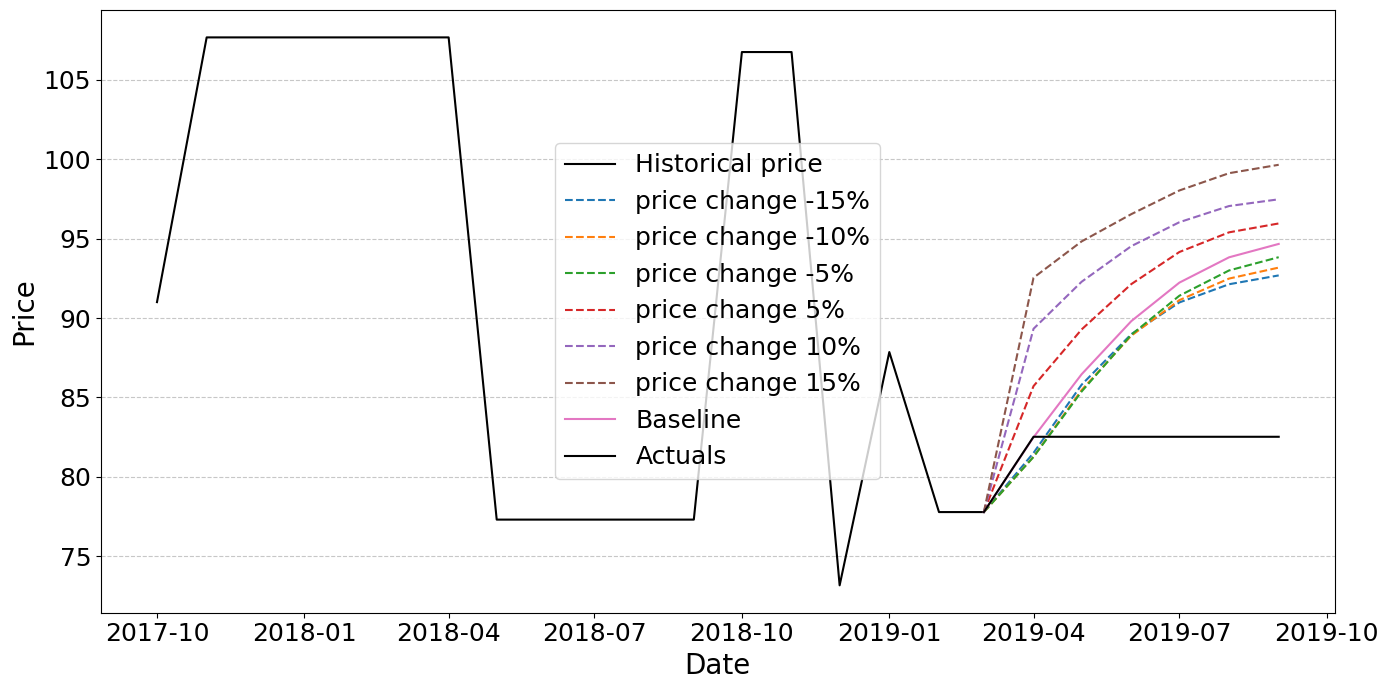

In [17]:
visualize_scenarios(data[input_col], scenarios_input, input_col)

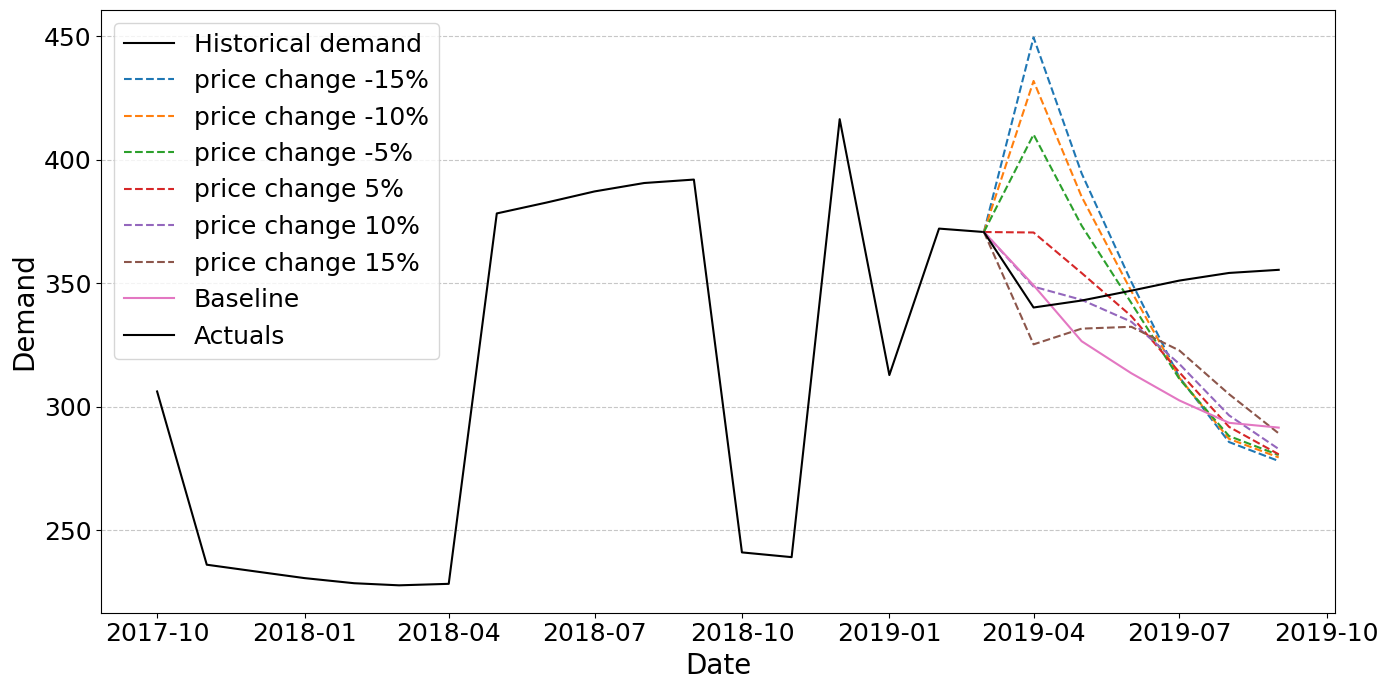

In [18]:
visualize_scenarios(data[output_col], scenarios_output, output_col)

#### 3.3. Generating scenarios of objective

Total **revenue** ...

In [19]:
# Calculate revenue

data[result_col] = data[input_col] * data[output_col]
scenarios_result = {}
total_revenue = {}

for price_scenario, demand_df in scenarios_output.items():
    demand_df = demand_df
    price_df = scenarios_input.get(price_scenario)

    if price_df is not None:
        revenue_df = (demand_df[output_col] * price_df[input_col]).to_frame(name=result_col)
        scenarios_result[price_scenario] = revenue_df
        total_revenue[price_scenario] = revenue_df.sum().values[0]

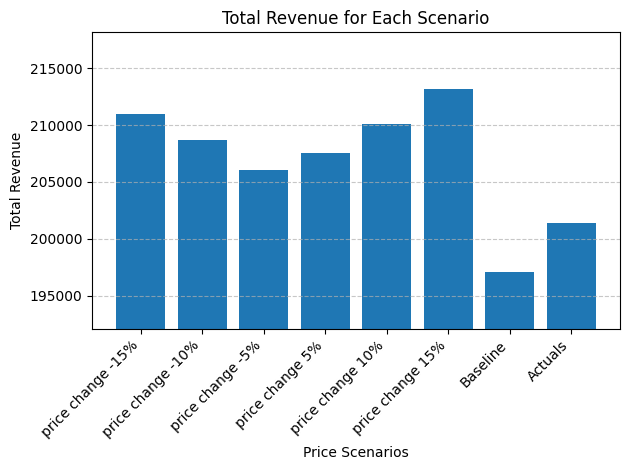

In [20]:
# Plot the total revenue for each scenario

plt.figure()
plt.bar(total_revenue.keys(), total_revenue.values())
plt.ylim([min(total_revenue.values()) - 5000, max(total_revenue.values()) + 5000])
plt.title('Total Revenue for Each Scenario')
plt.xlabel('Price Scenarios')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

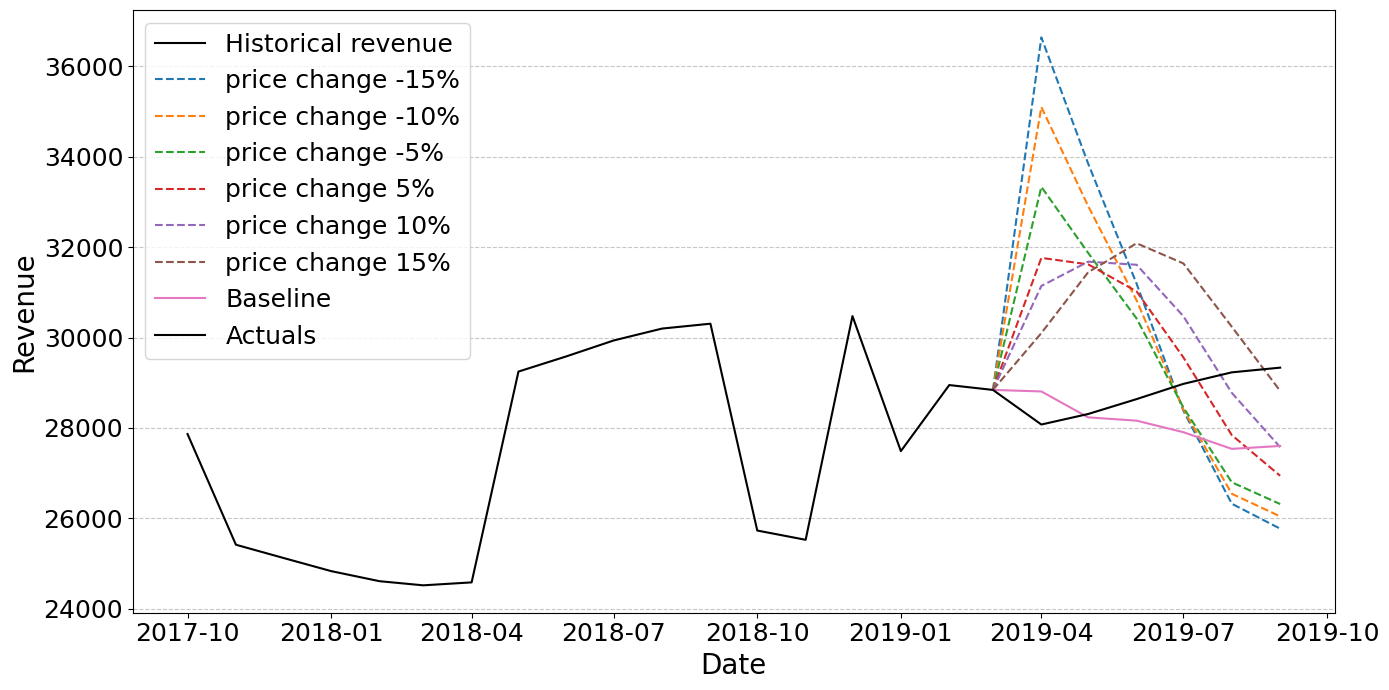

In [21]:
visualize_scenarios(data[result_col], scenarios_result, result_col)

#### 3.4. Evaluating scenarios

In [22]:
def evaluate_scenarios(actual_demand, forecasted_input, forecasted_output, input_col, output_col, baseline_scenario='Baseline', avg_inventory=100, promo_costs=500):
    """Function to evaluate scenario metrics"""

    metrics = []

    baseline_revenue = (forecasted_input[baseline_scenario][input_col] * forecasted_output[baseline_scenario][output_col]).sum()

    for scenario in forecasted_output.keys():
        forecast_price = forecasted_input[scenario][input_col]
        forecast_demand = forecasted_output[scenario][output_col]
        revenue = (forecast_price * forecast_demand).sum()
        avg_revenue = revenue / len(forecast_demand)
        revenue_uplift = ((revenue - baseline_revenue) / baseline_revenue) * 100

        # Forecast accuracy
        if len(actual_demand) == len(forecast_demand):
            mae = np.mean(np.abs(forecast_demand.values - actual_demand.values))
            rmse = np.sqrt(np.mean((forecast_demand.values - actual_demand.values)**2))
        else:
            mae, rmse = np.nan, np.nan

        # Inventory metrics using average inventory
        units_sold = forecast_demand.sum()
        inventory_turnover = units_sold / avg_inventory
        demand_fulfillment_rate = units_sold / forecast_demand.sum()

        # Business metrics using promotional costs
        roi = ((revenue - promo_costs) / promo_costs) * 100
        compactness = len(forecast_demand) / len(actual_demand)

        scenario_metrics = {
            'Scenario': scenario,
            'Total Revenue': revenue,
            'Avg Revenue per Period': avg_revenue,
            'Revenue Uplift (%)': revenue_uplift,
            'MAE (Demand)': mae,
            'RMSE (Demand)': rmse,
            'Inventory Turnover': inventory_turnover,
            'Demand Fulfillment (%)': demand_fulfillment_rate * 100,
            'ROI (%)': roi,
            'Window Compactness (%)': compactness * 100
        }

        metrics.append(scenario_metrics)

    return pd.DataFrame(metrics)

In [23]:
# Use demand actuals from test set
actual_demand = data_test[output_col]

scenario_results = evaluate_scenarios(actual_demand, scenarios_input, scenarios_output, input_col, output_col)

scenario_results

,Scenario,Total Revenue,Avg Revenue per Period,Revenue Uplift (%),MAE (Demand),RMSE (Demand),Inventory Turnover,Demand Fulfillment (%),ROI (%),Window Compactness (%)
0,price change -15%,210993.645592,30141.949370,7.059430,49.902577,61.898752,24.409709,100.0,42098.729118,100.0
1,price change -10%,208664.572719,29809.224674,5.877645,45.195007,56.060179,24.126880,100.0,41632.914544,100.0
2,price change -5%,206030.636366,29432.948052,4.541170,40.870026,49.871164,23.761823,100.0,41106.127273,100.0
3,price change 5%,207583.465418,29654.780774,5.329085,32.270551,41.381430,23.187311,100.0,41416.693084,100.0
4,price change 10%,210091.610731,30013.087247,6.601732,26.463428,37.709508,22.938220,100.0,41918.322146,100.0
5,price change 15%,213166.956352,30452.422336,8.162181,26.355927,34.137171,22.771153,100.0,42533.391270,100.0
6,Baseline,197080.859631,28154.408519,0.000000,33.134534,40.677650,22.476677,100.0,39316.171926,100.0
7,Actuals,201396.632209,28770.947458,2.189849,0.000000,0.000000,24.616068,100.0,40179.326442,100.0


In [24]:
## TODO: calculate overall metrics for all items in test_set

#### 3.5. Determining optimal profit window

The optimal profit window generation process involves finding a specific time segment within the forecast period that maximizes profit. Instead of assuming that the entire forecast length is optimal, the algorithm identifies the most profitable subset of the forecast, which could vary in size (from as small as one time step to the full forecast length) ...

In [25]:
def plot_optimal_window(original_series, forecasted_result, optimal):
    # Plot historical and forecasted revenue and highlight the optimal window

    if optimal["scenario"] is None:
        print("No optimal window found.")
        return

    plt.figure(figsize=(14, 7))
    
    # Historical revenue
    plt.plot(original_series.index, original_series.values, label="Historical", color="black", linewidth=2)
    global_min = original_series.min()
    
    # Forecasted revenue for each scenario
    for scenario, series in forecasted_result.items():
        if isinstance(series, pd.DataFrame):
            series = series.iloc[:, 0]
        if scenario == "Actuals":
            plt.plot(series.index, series.values, label=f"{scenario}", color='black')
        else:
            plt.plot(series.index, series.values, label=f"{scenario}")
        global_min = min(global_min, series.min())
    
    # Extract optimal window details.
    scenario = optimal["scenario"]
    start = optimal["start"]
    end = optimal["end"]
    series = forecasted_result[scenario]
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]
    window_segment = series.iloc[start:end + 1]
    
    # Highlight the optimal window.
    plt.fill_between(window_segment.index, global_min, window_segment.values,
                     color="yellow", alpha=0.3,
                     label=f"Optimal window: {scenario} ({start}-{end})")
    
    #plt.title("Optimal outcome window")
    plt.xlabel("Time", fontsize=plot_font_size+4)
    plt.ylabel("Revenue", fontsize=plot_font_size+4)
    plt.xticks(fontsize=plot_font_size+2)
    plt.yticks(fontsize=plot_font_size+2)
    plt.legend(fontsize=plot_font_size+2)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    
    plt.show()

Optimal scenario: price change -15%
Window: 1 to 2
Score: 35244.31


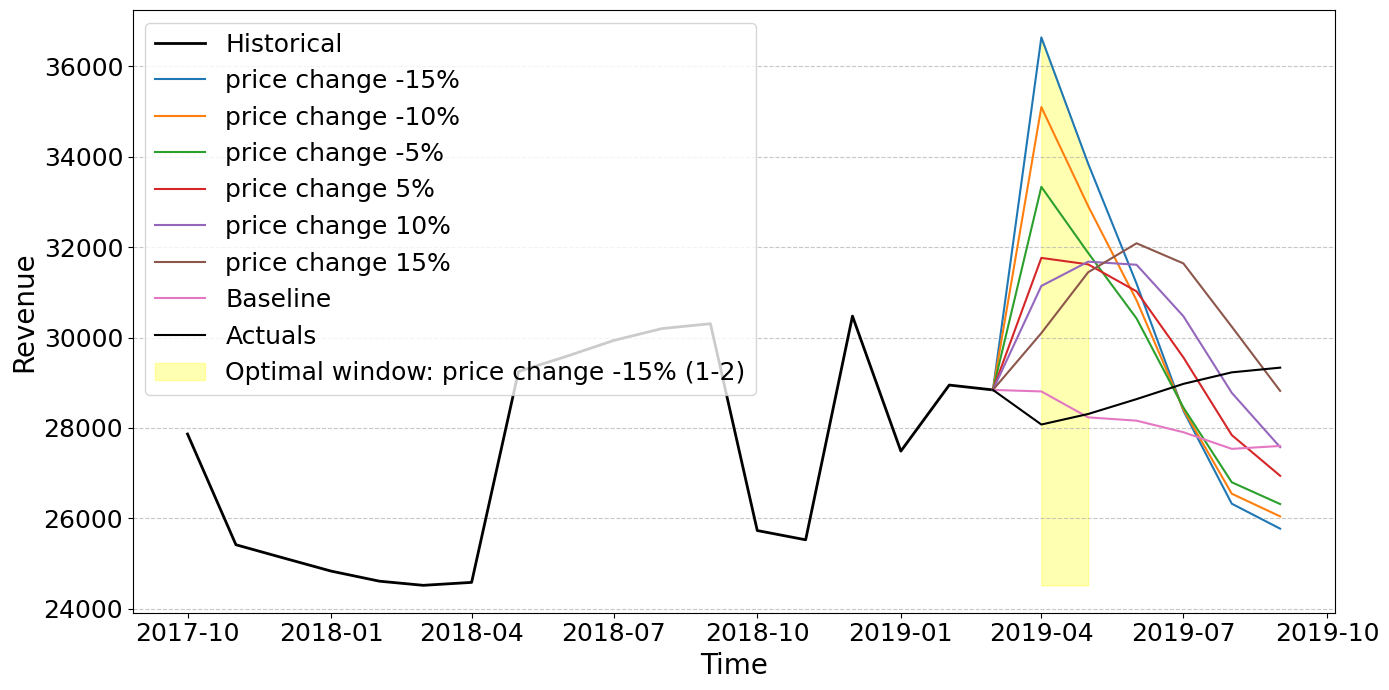

In [26]:
optimal_window = scenario_generator.find_optimal_window_with_demand(
    scenarios_result,
    scenarios_output,
    penalty_factor=0.1,
    demand_weight=1.5,
    min_window_size=2,
    max_window_size=5
)

print(f"Optimal scenario: {optimal_window['scenario']}")
print(f"Window: {optimal_window['start']} to {optimal_window['end']}")
print(f"Score: {optimal_window['score']:.2f}")

plot_optimal_window(data["revenue"], scenarios_result, optimal_window)

----------------

### 4. Validation

Adding xgboost and loglinear methods and compare it to the proposed method

In [27]:
xgb_model = XGBoostScenarioGeneration()
xgb_model.train(train_df, input_col='price', output_col='demand')

In [28]:
loglinear_model = LogLinearScenarioGeneration()
loglinear_model.train(train_df, input_col='price', output_col='demand')

In [29]:
xgb_input, xgb_output = xgb_model.generate_scenarios(data, price_change_percentages, forecast_length=forecast_length)
loglinear_input, loglinear_output = loglinear_model.generate_scenarios(data, price_change_percentages, forecast_length=forecast_length)

xgb_input['Actuals'] = data_test[[output_col]]
xgb_output['Actuals'] = data_test[[output_col]]


/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/xgboost_scenarios.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_index + pd.DateOffset(months=1), periods=forecast_length, freq='M')
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/loglinear_scenarios.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_index + pd.DateOffset(months=1), periods=forecast_length, freq='M')
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site

#### 4.1. Evaluating the accuracy of forecasting models

In [30]:
def evaluate_model(df, model, col, steps):
    results_list = []

    for (item, store), group in df.groupby(["item_id", "store_id"]):
        print(f"\nForecasting for {item} - {store}")

        # Using col for forecasting
        input_values = group[col].dropna().values

        if len(input_values) < steps:
            print(f"Skipping {item}-{store}: Not enough data.")
            continue

        # Forecast last `steps` days
        predicted_values = model.forecast(input_values[:-steps], steps)

        # Compute error metrics
        actual_values = input_values[-steps:]

        mape = mean_absolute_percentage_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

        results_list.append({
            "item_id": item,
            "store_id": store,
            "MAPE": mape,
            "MAE": mae,
            "RMSE": rmse
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results_list)

    # Compute overall error metrics
    metrics = {
        "Overall_MAPE": results_df["MAPE"].mean(), 
        "Overall_MAE": results_df["MAE"].mean(), 
        "Overall_RMSE": results_df["RMSE"].mean()
    }

    return results_df, metrics

In [31]:
def evaluate_regression_model(df, model, col, steps, log_transform=True):
    results_list = []

    for (item, store), group in df.groupby(["item_id", "store_id"]):
        print(f"\nForecasting for {item} - {store}")

        input_values = group[col].dropna().values

        if len(input_values) < steps + 1:
            print(f"Skipping {item}-{store}: Not enough data.")
            continue

        X = input_values[:-steps].reshape(-1, 1)
        y_actual = input_values[-steps:]
        
        if log_transform:
            X_transformed = np.log(X)
            preds = model.predict(X_transformed[-steps:])
            y_pred = np.exp(preds)
        else:
            preds = model.predict(X[-steps:])
            y_pred = preds

        mape = mean_absolute_percentage_error(y_actual, y_pred)
        mae = mean_absolute_error(y_actual, y_pred)
        rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

        results_list.append({
            "item_id": item,
            "store_id": store,
            "MAPE": mape,
            "MAE": mae,
            "RMSE": rmse
        })

    results_df = pd.DataFrame(results_list)
    metrics = {
        "Overall_MAPE": results_df["MAPE"].mean(),
        "Overall_MAE": results_df["MAE"].mean(),
        "Overall_RMSE": results_df["RMSE"].mean()
    }

    return results_df, metrics

In [32]:
#results_input_df, metrics_input = evaluate_model(test_df, model_input, input_col, forecast_length)
transformer_results, transformer_metrics = evaluate_model(test_df, model_output, output_col, forecast_length)

xgb_results, xgb_metrics = evaluate_regression_model(test_df, xgb_model.model, col='demand', steps=forecast_length, log_transform=True)

loglinear_results, loglinear_metrics = evaluate_regression_model(test_df, loglinear_model.model, col='demand', steps=forecast_length, log_transform=True)


Forecasting for item_241 - store_001

Forecasting for item_242 - store_001

Forecasting for item_243 - store_001

Forecasting for item_244 - store_001

Forecasting for item_245 - store_001

Forecasting for item_246 - store_001

Forecasting for item_247 - store_001

Forecasting for item_248 - store_001

Forecasting for item_249 - store_001

Forecasting for item_250 - store_001

Forecasting for item_251 - store_001

Forecasting for item_252 - store_001

Forecasting for item_253 - store_001

Forecasting for item_254 - store_001

Forecasting for item_255 - store_001

Forecasting for item_256 - store_001

Forecasting for item_257 - store_001

Forecasting for item_258 - store_001

Forecasting for item_259 - store_001

Forecasting for item_260 - store_001

Forecasting for item_261 - store_001

Forecasting for item_262 - store_001

Forecasting for item_263 - store_001

Forecasting for item_264 - store_001

Forecasting for item_265 - store_001

Forecasting for item_266 - store_001

Forecasting

/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3

In [33]:
print("Overall test metrics output:", transformer_metrics)
print("XGBoost Forecasting Metrics:", xgb_metrics)
print("LogLinear Forecasting Metrics:", loglinear_metrics)

Overall test metrics output: {'Overall_MAPE': 0.15776827906808835, 'Overall_MAE': 47.717735851004036, 'Overall_RMSE': 54.54542686401759}
XGBoost Forecasting Metrics: {'Overall_MAPE': 0.1966163125024063, 'Overall_MAE': 68.33430955135415, 'Overall_RMSE': 78.35750617749815}
LogLinear Forecasting Metrics: {'Overall_MAPE': 0.7000066682250913, 'Overall_MAE': 220.3978835734994, 'Overall_RMSE': 224.5245276814033}


In [34]:
"""
def mean_absolute_percentage_error(y_true, y_pred):
    #Standard MAPE function
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_scenario_accuracy(actual, predicted):
    #Evaluates scenario forecasting accuracy
    return {
        "MAE": mean_absolute_error(actual, predicted),
        "RMSE": np.sqrt(mean_squared_error(actual, predicted)),
        "MAPE": mean_absolute_percentage_error(actual, predicted)
    }

def evaluate_economic_metrics(input_df, output_df, input_col, output_col, promo_costs=500, avg_inventory=100):
    #Evaluate revenue, ROI, and inventory KPIs
    price = input_df[input_col].values
    demand = output_df[output_col].values
    revenue = np.sum(price * demand)
    roi = ((revenue - promo_costs) / promo_costs) * 100
    turnover = np.sum(demand) / avg_inventory
    return {
        "Total Revenue": revenue,
        "ROI (%)": roi,
        "Inventory Turnover": turnover
    }

def compare_with_baseline(scenarios_output, baseline_output, output_col):
    #Compares each scenario against the baseline for revenue uplift
    baseline_revenue = np.sum(
        baseline_output[output_col].values * scenarios_input['Baseline'][input_col].values
    )
    metrics = {}
    for scenario, df in scenarios_output.items():
        if scenario in ['Baseline', 'Actuals']:
            continue
        scenario_revenue = np.sum(df[output_col].values * scenarios_input[scenario][input_col].values)
        uplift = (scenario_revenue - baseline_revenue) / baseline_revenue * 100
        metrics[scenario] = uplift
    return metrics
"""

'\ndef mean_absolute_percentage_error(y_true, y_pred):\n    #Standard MAPE function\n    y_true = np.array(y_true)\n    y_pred = np.array(y_pred)\n    mask = y_true != 0\n    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100\n\ndef evaluate_scenario_accuracy(actual, predicted):\n    #Evaluates scenario forecasting accuracy\n    return {\n        "MAE": mean_absolute_error(actual, predicted),\n        "RMSE": np.sqrt(mean_squared_error(actual, predicted)),\n        "MAPE": mean_absolute_percentage_error(actual, predicted)\n    }\n\ndef evaluate_economic_metrics(input_df, output_df, input_col, output_col, promo_costs=500, avg_inventory=100):\n    #Evaluate revenue, ROI, and inventory KPIs\n    price = input_df[input_col].values\n    demand = output_df[output_col].values\n    revenue = np.sum(price * demand)\n    roi = ((revenue - promo_costs) / promo_costs) * 100\n    turnover = np.sum(demand) / avg_inventory\n    return {\n        "Total Revenue": revenue,\n    

In [35]:
"""
scm_scores = {}
xgb_scores = {}

for scenario in scenarios_output:
    if scenario in ['Baseline', 'Actuals']:
        continue

    actual = data_test[output_col].values
    scm_forecast = scenarios_output[scenario][output_col].values
    xgb_forecast = xgb_output[scenario][output_col].values

    scm_scores[scenario] = evaluate_scenario_accuracy(actual, scm_forecast)
    xgb_scores[scenario] = evaluate_scenario_accuracy(actual, xgb_forecast)
"""

"\nscm_scores = {}\nxgb_scores = {}\n\nfor scenario in scenarios_output:\n    if scenario in ['Baseline', 'Actuals']:\n        continue\n\n    actual = data_test[output_col].values\n    scm_forecast = scenarios_output[scenario][output_col].values\n    xgb_forecast = xgb_output[scenario][output_col].values\n\n    scm_scores[scenario] = evaluate_scenario_accuracy(actual, scm_forecast)\n    xgb_scores[scenario] = evaluate_scenario_accuracy(actual, xgb_forecast)\n"

Visualize scenarios

In [36]:
#visualize_scenarios(data[output_col], loglinear_output, input_col)
#visualize_scenarios(data[output_col], xgb_output, input_col)

-----------

#### 4.2. Evaluating the scenarios

In [37]:
def check_monotonicity(scenarios_output):
    # Check if demand changes consistently with price changes
    results = {}
    for scenario, df in scenarios_output.items():
        try:
            pct_change = df.iloc[:, 0].pct_change().dropna()
            results[scenario] = (pct_change > -1).all()
        except Exception:
            results[scenario] = False
    return results

def compute_scenario_elasticity(scenarios_input, scenarios_output):
    # Compute elasticity for each scenario using log-log regression
    elasticities = {}
    for scenario in scenarios_input:
        try:
            price = np.log(scenarios_input[scenario].iloc[:, 0])
            demand = np.log(scenarios_output[scenario].iloc[:, 0])
            slope, _, _, _, _ = linregress(price, demand)
            elasticities[scenario] = slope
        except Exception:
            elasticities[scenario] = np.nan
    return elasticities

def compute_scenario_robustness(scenarios_output):
    # Compute variance of output across similar interventions (robustness)
    lengths = [len(df) for df in scenarios_output.values()]
    min_len = min(lengths)
    aligned_outputs = np.array([df.iloc[:min_len, 0].values for df in scenarios_output.values()])
    std_devs = np.std(aligned_outputs, axis=0)
    return np.mean(std_devs)

def evaluate_economic_plausibility(scenarios_input, scenarios_output):
    # Check if demand decreases when price increases and vice versa
    plausible = {}
    for scenario in scenarios_input:
        try:
            price = scenarios_input[scenario].iloc[:, 0].values
            demand = scenarios_output[scenario].iloc[:, 0].values
            correlation = np.corrcoef(price, demand)[0, 1]
            plausible[scenario] = correlation < 0
        except Exception:
            plausible[scenario] = False
    return plausible


In [38]:
def evaluate_all_metrics(scm_input, scm_output, xgb_input, xgb_output, loglinear_input, loglinear_output):
    print("Evaluating Monotonicity...")
    mono_scm = check_monotonicity(scm_output)
    mono_xgb = check_monotonicity(xgb_output)
    mono_loglinear = check_monotonicity(loglinear_output)

    print("Computing Elasticities...")
    scm_elasticity = compute_scenario_elasticity(scm_input, scm_output)
    xgb_elasticity = compute_scenario_elasticity(xgb_input, xgb_output)
    loglinear_elasticity = compute_scenario_elasticity(loglinear_input, loglinear_output)

    print("Evaluating Robustness...")
    scm_robustness = compute_scenario_robustness(scm_output)
    xgb_robustness = compute_scenario_robustness(xgb_output)
    loglinear_robustness = compute_scenario_robustness(loglinear_output)

    print("Evaluating Economic Plausibility...")
    scm_plausibility = evaluate_economic_plausibility(scm_input, scm_output)
    xgb_plausibility = evaluate_economic_plausibility(xgb_input, xgb_output)
    loglinear_plausibility = evaluate_economic_plausibility(loglinear_input, loglinear_output)

    comparison_df = pd.DataFrame({
        "TBWISA Monotonic": pd.Series(mono_scm),
        "XGB Monotonic": pd.Series(mono_xgb),
        "Log-linear Monotonic": pd.Series(mono_loglinear),
        "TBWISA Elasticity": pd.Series(scm_elasticity),
        "XGB Elasticity": pd.Series(xgb_elasticity),
        "Log-linear Elasticity": pd.Series(loglinear_elasticity),
        "TBWISA Plausible": pd.Series(scm_plausibility),
        "XGB Plausible": pd.Series(xgb_plausibility),
        "Log-linear Plausible": pd.Series(loglinear_plausibility)
    })

    print(f"\nAverage Robustness (Lower is Better):")
    print(f"  TBWISA: {scm_robustness:.4f}")
    print(f"  XGB: {xgb_robustness:.4f}")
    print(f"  Log-linear: {loglinear_robustness:.4f}")

    return comparison_df, scm_elasticity, xgb_elasticity, loglinear_elasticity, scm_plausibility, xgb_plausibility, loglinear_plausibility

In [39]:
filtered_scm_input = {k: v for k, v in scenarios_input.items() if k not in ['Actuals', 'Baseline', 'price change 0%']}
filtered_scm_output = {k: v for k, v in scenarios_output.items() if k not in ['Actuals', 'Baseline', 'price change 0%']}
filtered_xgb_input = {k: v for k, v in xgb_input.items() if k not in ['Actuals', 'Baseline', 'price change 0%']}
filtered_xgb_output = {k: v for k, v in xgb_output.items() if k not in ['Actuals', 'Baseline', 'price change 0%']}
filtered_loglinear_input = {k: v for k, v in loglinear_input.items() if k not in ['Actuals', 'Baseline', 'price change 0%']}
filtered_loglinear_output = {k: v for k, v in loglinear_output.items() if k not in ['Actuals', 'Baseline', 'price change 0%']}

comparison_results, scm_elasticity, xgb_elasticity, loglinear_elasticity, scm_plausibility, xgb_plausibility, loglinear_plausibility = evaluate_all_metrics(
    filtered_scm_input, filtered_scm_output,
    filtered_xgb_input, filtered_xgb_output,
    filtered_loglinear_input, filtered_loglinear_output
)

comparison_results

Evaluating Monotonicity...
Computing Elasticities...
Evaluating Robustness...
Evaluating Economic Plausibility...

Average Robustness (Lower is Better):
  TBWISA: 12.5966
  XGB: 16.0983
  Log-linear: 40.8957


,TBWISA Monotonic,XGB Monotonic,Log-linear Monotonic,TBWISA Elasticity,XGB Elasticity,Log-linear Elasticity,TBWISA Plausible,XGB Plausible,Log-linear Plausible
price change -15%,True,True,True,-2.084642,-0.534256,-1.463545,True,True,True
price change -10%,True,True,True,-1.949119,-0.824091,-1.661978,True,True,True
price change -5%,True,True,True,-1.763070,-1.692749,-2.256695,True,True,True
price change 5%,True,True,True,-1.258757,0.310365,0.120609,True,False,False
price change 10%,True,True,True,-0.982665,0.371486,-0.474071,True,False,True
price change 15%,True,True,True,-0.773245,-0.332615,-0.672441,True,True,True


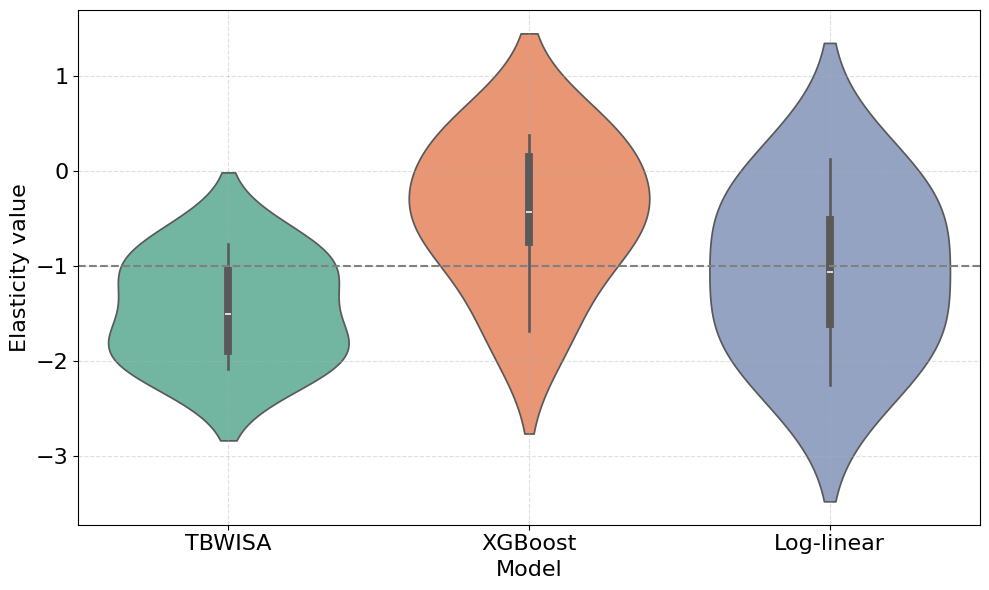

In [40]:
def plot_elasticity_violin(scm_elasticity, xgb_elasticity, loglinear_elasticity):
    df = pd.DataFrame({
        'TBWISA': pd.Series(scm_elasticity),
        'XGBoost': pd.Series(xgb_elasticity),
        'Log-linear': pd.Series(loglinear_elasticity)
    })

    df_melted = df.melt(var_name='Model', value_name='Elasticity').dropna()

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_melted, x='Model', y='Elasticity', hue='Model', palette="Set2", legend=False)
    #sns.violinplot(data=df_melted, x='Model', y='Elasticity', palette="Set2")
    plt.axhline(-1, color='gray', linestyle='--', label='Elasticity = -1')
    #plt.title("Elasticity distribution for each model")
    plt.xlabel("Model", fontsize=plot_font_size)
    plt.ylabel("Elasticity value", fontsize=plot_font_size)
    plt.xticks(fontsize=plot_font_size)
    plt.yticks(fontsize=plot_font_size)
    #plt.legend(fontsize=plot_font_size)
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

plot_elasticity_violin(scm_elasticity, xgb_elasticity, loglinear_elasticity)

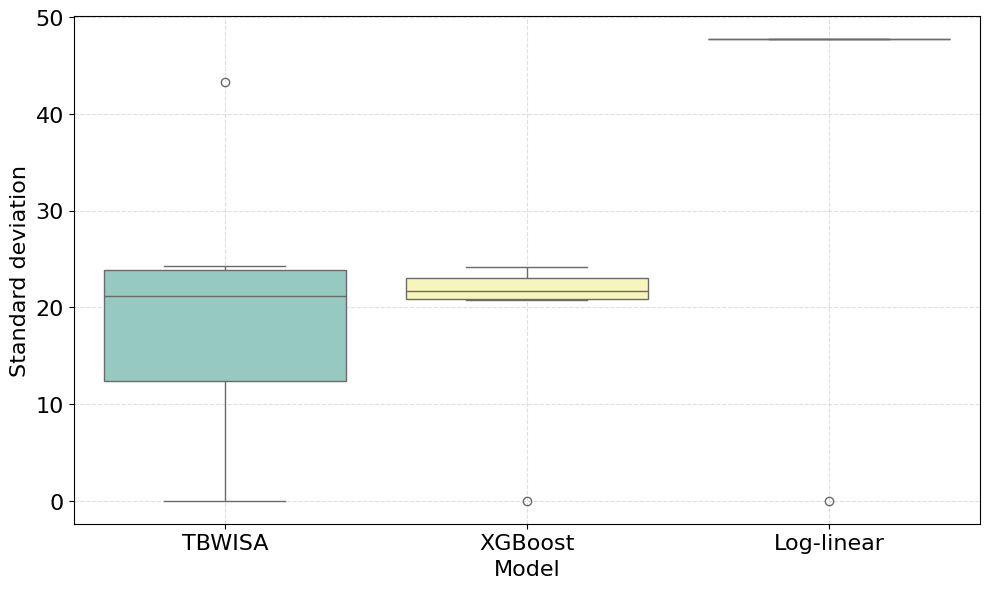

In [41]:
def plot_robustness_boxplot(scenarios_output, xgb_output, loglinear_output):
    def compute_std_list(df_dict):
        min_len = min(len(df) for df in df_dict.values())
        aligned = np.array([df.iloc[:min_len, 0].values for df in df_dict.values()])
        return np.std(aligned, axis=0)

    std_scm = compute_std_list(scenarios_output)
    std_xgb = compute_std_list(xgb_output)
    std_loglinear = compute_std_list(loglinear_output)

    df = pd.DataFrame({
        'TBWISA': std_scm,
        'XGBoost': std_xgb,
        'Log-linear': std_loglinear
    })

    df_melted = df.melt(var_name='Model', value_name='Standard deviation')

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x='Model', y='Standard deviation', hue='Model', palette="Set3", legend=False)
    #sns.boxplot(data=df_melted, x='Model', y='Standard deviation', palette="Set3")
    #plt.title("Forecast robustness comparison")
    plt.xlabel("Model", fontsize=plot_font_size)
    plt.ylabel("Standard deviation", fontsize=plot_font_size) #lower is more robust
    plt.xticks(fontsize=plot_font_size)
    plt.yticks(fontsize=plot_font_size)
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

plot_robustness_boxplot(scenarios_output, xgb_output, loglinear_output)
#plot_robustness_boxplot(filtered_scm_output, filtered_xgb_output, filtered_loglinear_output)

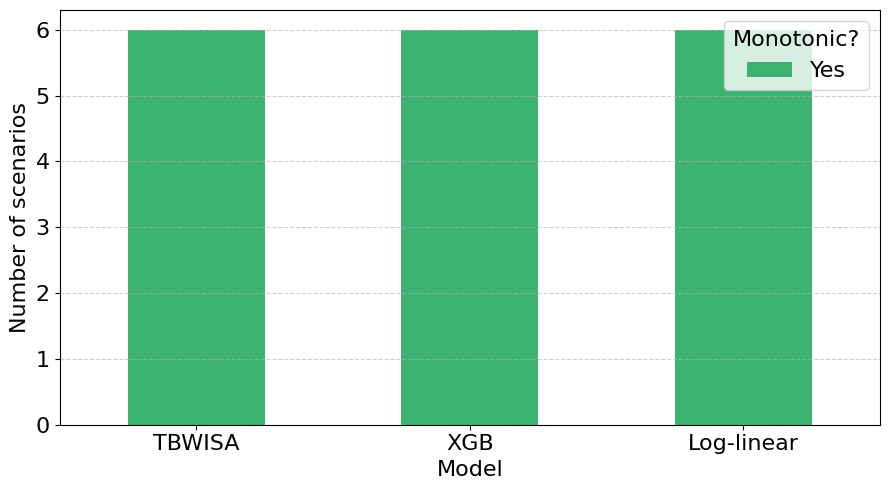

In [42]:
def plot_monotonicity_bar(mono_scm, mono_xgb, mono_loglinear):
    scm_series = pd.Series(mono_scm, name="TBWISA")
    xgb_series = pd.Series(mono_xgb, name="XGB")
    loglinear_series = pd.Series(mono_loglinear, name="Log-linear")

    df = pd.concat([scm_series, xgb_series, loglinear_series], axis=1)
    df_sum = df.apply(lambda col: col.value_counts()).fillna(0).astype(int)

    ax = df_sum.T.plot(kind="bar", stacked=True, color=["mediumseagreen", "tomato"], figsize=(9, 5))
    #plt.title("Monotonicity consistency by scenario")
    plt.xlabel("Model", fontsize=plot_font_size)
    plt.ylabel("Number of scenarios", fontsize=plot_font_size)
    handles, labels = ax.get_legend_handles_labels()
    labels = ["False (No)", "True (Yes)"] if "False" in labels else ["Yes", "No"]
    ax.legend(handles, labels, title="Monotonic?", fontsize=plot_font_size, title_fontsize=plot_font_size)
    plt.xticks(fontsize=plot_font_size, rotation=0)
    plt.yticks(fontsize=plot_font_size)
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

plot_monotonicity_bar(comparison_results["TBWISA Monotonic"], comparison_results["XGB Monotonic"], comparison_results["Log-linear Monotonic"])

In [43]:
comparison_results

,TBWISA Monotonic,XGB Monotonic,Log-linear Monotonic,TBWISA Elasticity,XGB Elasticity,Log-linear Elasticity,TBWISA Plausible,XGB Plausible,Log-linear Plausible
price change -15%,True,True,True,-2.084642,-0.534256,-1.463545,True,True,True
price change -10%,True,True,True,-1.949119,-0.824091,-1.661978,True,True,True
price change -5%,True,True,True,-1.763070,-1.692749,-2.256695,True,True,True
price change 5%,True,True,True,-1.258757,0.310365,0.120609,True,False,False
price change 10%,True,True,True,-0.982665,0.371486,-0.474071,True,False,True
price change 15%,True,True,True,-0.773245,-0.332615,-0.672441,True,True,True


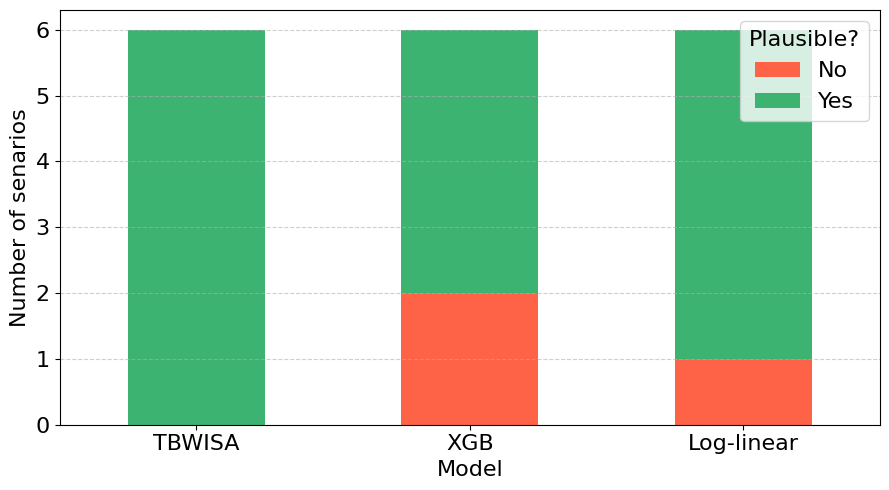

In [44]:
def plot_economic_plausibility(scm_plausible, xgb_plausible, loglinear_plausible):
    scm_series = pd.Series(scm_plausible, name="TBWISA")
    xgb_series = pd.Series(xgb_plausible, name="XGB")
    loglinear_series = pd.Series(loglinear_plausible, name="Log-linear")

    df = pd.concat([scm_series, xgb_series, loglinear_series], axis=1)
    df_sum = df.apply(lambda col: col.value_counts()).fillna(0).astype(int)

    df_sum.T.plot(kind="bar", stacked=True, color=["tomato", "mediumseagreen"], figsize=(9, 5))
    #plt.title("Economic plausibility verification by scenario")
    plt.xlabel("Model", fontsize=plot_font_size)
    plt.ylabel("Number of senarios", fontsize=plot_font_size)
    plt.legend(title="Plausible?", labels=["No", "Yes"], fontsize=plot_font_size, title_fontsize=plot_font_size)
    plt.xticks(fontsize=plot_font_size, rotation=0)
    plt.yticks(fontsize=plot_font_size)
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

plot_economic_plausibility(scm_plausibility, xgb_plausibility, loglinear_plausibility)

In [45]:
scm_plausibility

{'price change -15%': True,
 'price change -10%': True,
 'price change -5%': True,
 'price change 5%': True,
 'price change 10%': True,
 'price change 15%': True}

In [46]:
def plot_scenario_overlays(scenarios_output, xgb_output, loglinear_output, title="Scenario Forecast Comparison"):
    min_len = min(
        min(len(df) for df in scenarios_output.values()),
        min(len(df) for df in xgb_output.values()),
        min(len(df) for df in loglinear_output.values())
    )

    plt.figure(figsize=(12, 6))
    
    for label, outputs, color in [
        ("TBWISA", scenarios_output, "royalblue"),
        ("XGB", xgb_output, "orange"),
        ("Log-linear", loglinear_output, "green")
    ]:
        for scenario, df in outputs.items():
            values = df.iloc[:min_len, 0].values
            plt.plot(range(min_len), values, label=f"{label}: {scenario}", alpha=0.4)

    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Forecasted demand")
    plt.legend(ncol=3, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, 1.25))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_elasticity_distributions(scm_elasticity, xgb_elasticity, loglinear_elasticity):
    scm_vals = pd.Series(scm_elasticity).dropna()
    xgb_vals = pd.Series(xgb_elasticity).dropna()
    loglinear_vals = pd.Series(loglinear_elasticity).dropna()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(scm_vals, label='TBWISA Elasticity', linewidth=2)
    sns.kdeplot(xgb_vals, label='XGB Elasticity', linewidth=2)
    sns.kdeplot(loglinear_vals, label='Log-linear Elasticity', linewidth=2)
    plt.axvline(-1, color='gray', linestyle='--', label='Typical Elasticity Threshold')
    plt.title("Elasticity distribution for each scenario")
    plt.xlabel("Elasticity value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_elasticity(scm_elasticity, xgb_elasticity, loglinear_elasticity):
    elasticity_df = pd.DataFrame({
        'Scenario': comparison_results.index,
        'TBWISA Elasticity': list(scm_elasticity.values()),
        'XGB Elasticity': list(xgb_elasticity.values()),
        'Loglinear Elasticity': list(loglinear_elasticity.values())
    })
    elasticity_df.set_index('Scenario', inplace=True)

    plt.figure(figsize=(10, 6))
    plt.plot(elasticity_df.index, elasticity_df['TBWISA Elasticity'], marker='o', label='TBWISA', color='steelblue')
    plt.plot(elasticity_df.index, elasticity_df['XGB Elasticity'], marker='s', label='XGBoost', color='darkorange')
    plt.plot(elasticity_df.index, elasticity_df['Loglinear Elasticity'], marker='s', label='Loglinear', color='green')

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.ylabel('Elasticity')
    plt.title('Elasticity Comparison Between TBWISA and XGBoost Scenarios')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_robustness_over_time(scm_output, xgb_output, loglinear_output):
    def align_and_std(df_dict):
        min_len = min(len(df) for df in df_dict.values())
        aligned = np.array([df.iloc[:min_len, 0].values for df in df_dict.values()])
        return np.std(aligned, axis=0)

    std_scm = align_and_std(scm_output)
    std_xgb = align_and_std(xgb_output)
    std_loglinear = align_and_std(loglinear_output)

    plt.figure(figsize=(10, 5))
    plt.plot(std_scm, label="TBWISA Std Dev", linewidth=2)
    plt.plot(std_xgb, label="XGB Std Dev", linewidth=2)
    plt.plot(std_loglinear, label="Log-linear Std Dev", linewidth=2)
    plt.title("Scenario robustness")
    plt.xlabel("Forecast time step")
    plt.ylabel("Standard deviation")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_elasticity_accuracy_ranking(scm_elasticity, xgb_elasticity, loglinear_elasticity, target=-1.0):
    def distance_to_target(elasticities):
        return {k: abs(v - target) for k, v in elasticities.items() if not np.isnan(v)}

    scm_error = distance_to_target(scm_elasticity)
    xgb_error = distance_to_target(xgb_elasticity)
    loglinear_error = distance_to_target(loglinear_elasticity)

    df = pd.DataFrame({
        "TBWISA Error": pd.Series(scm_error),
        "XGB Error": pd.Series(xgb_error),
        "Log-linear Error": pd.Series(loglinear_error)
    })

    df["Best Model"] = df.idxmin(axis=1).str.replace(" Error", "")

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x="Best Model", palette="Set1")
    plt.title("Elasticity accuracy ranking by scenario")
    plt.xlabel("Model (Closest to elasticity -1 is better)")
    plt.ylabel("Number of scenarios")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

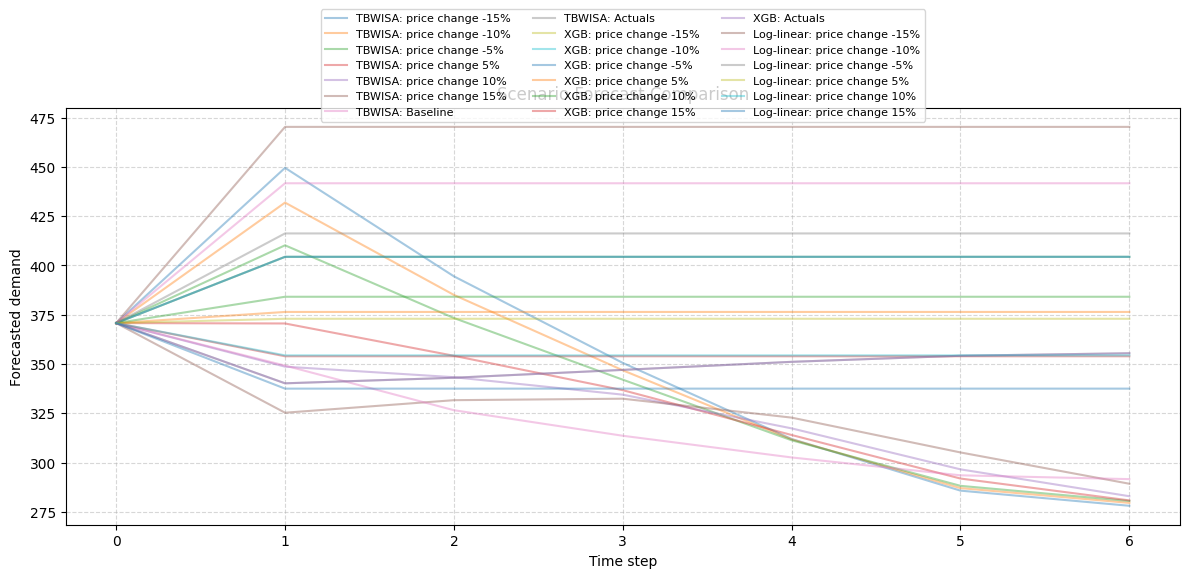

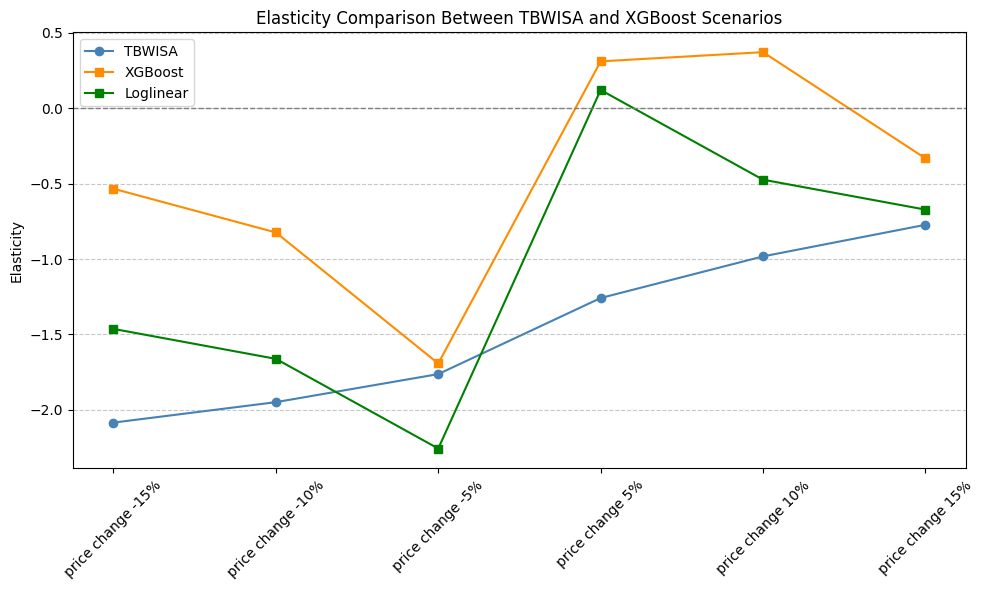

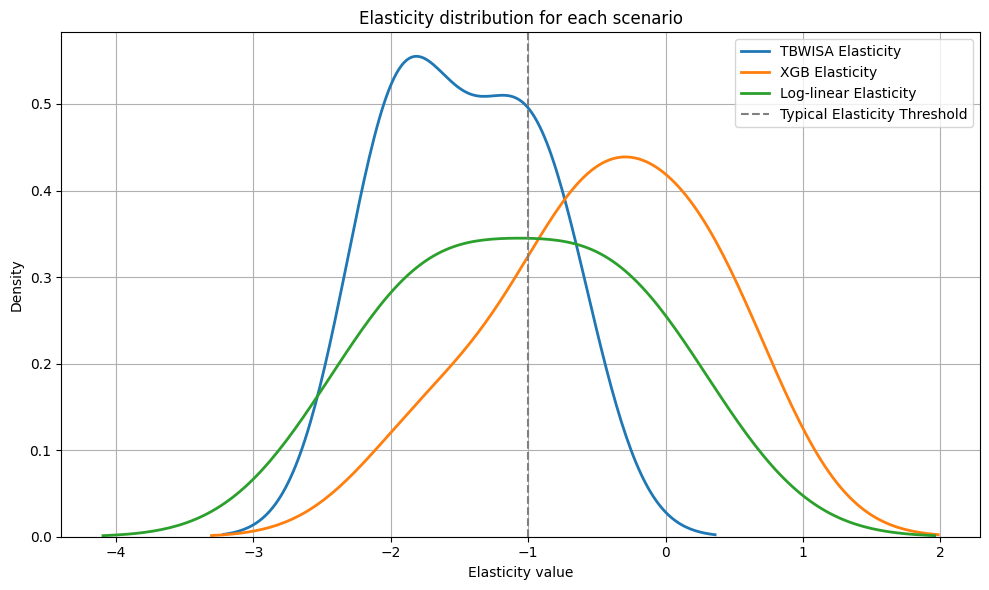

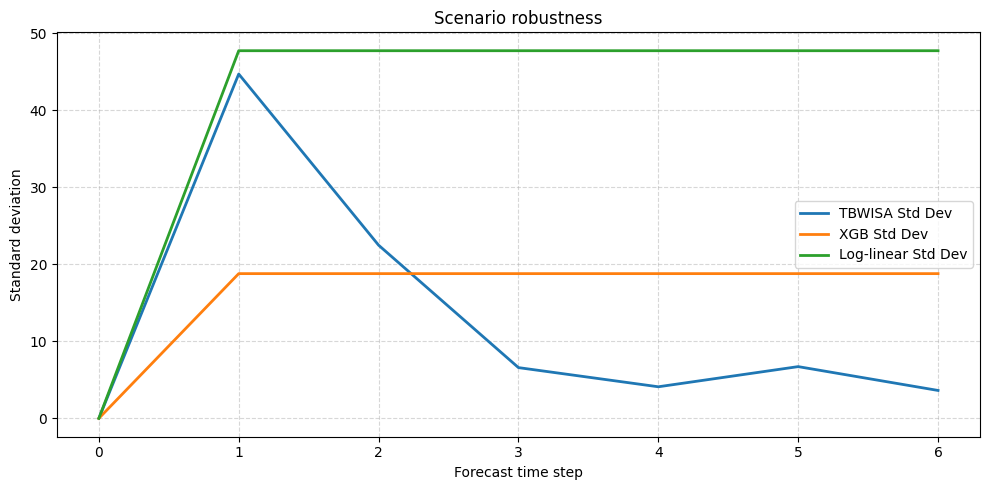

/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_80998/656248776.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Best Model", palette="Set1")


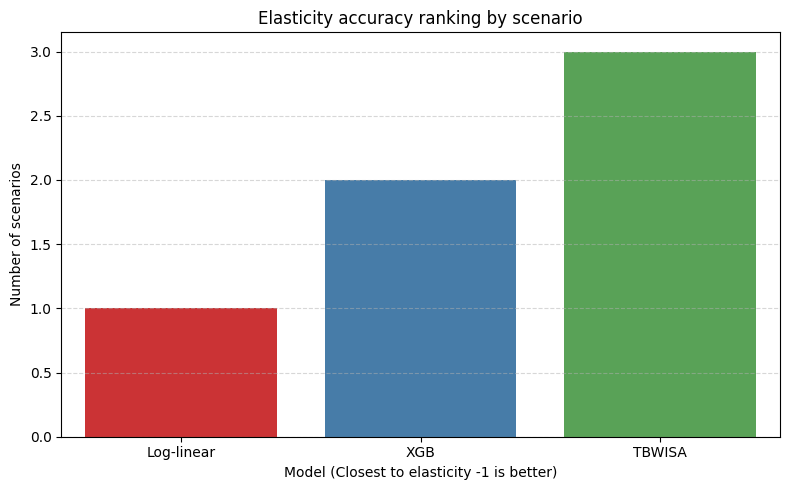

In [47]:
plot_scenario_overlays(scenarios_output, xgb_output, loglinear_output)

plot_elasticity(scm_elasticity, xgb_elasticity, loglinear_elasticity)

plot_elasticity_distributions(scm_elasticity, xgb_elasticity, loglinear_elasticity)

plot_robustness_over_time(filtered_scm_output, filtered_xgb_output, filtered_loglinear_output)

plot_elasticity_accuracy_ranking(scm_elasticity, xgb_elasticity, loglinear_elasticity)

In [48]:
def radar_chart_comparison(metrics_dict):
    labels = list(next(iter(metrics_dict.values())).keys())
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    for model, metrics in metrics_dict.items():
        values = list(metrics.values())
        values += values[:1]
        ax.plot(angles, values, label=model)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
    plt.title("Model Validation Radar Chart")
    plt.tight_layout()
    plt.show()


In [49]:
metrics_dict = {
    "TBWISA": {"Monotonicity": 1.0, "Economic Plausibility": 1.0},
    "XGBoost": {"Monotonicity": 1.0, "Economic Plausibility": 0.67},
    "Log-linear": {"Monotonicity": 1.0, "Economic Plausibility": 0.83}
}

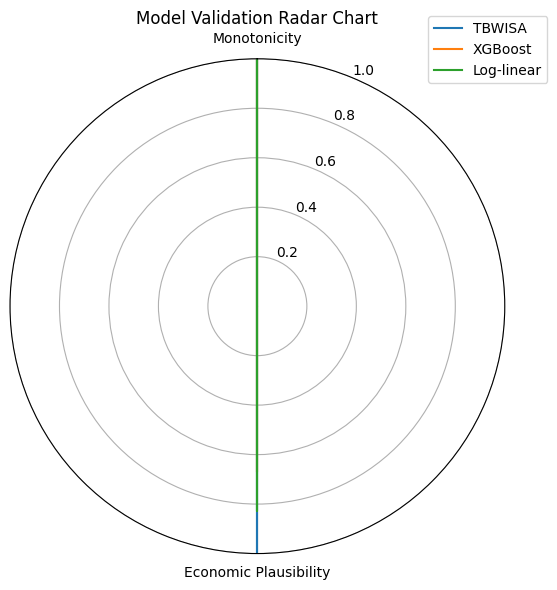

In [50]:
radar_chart_comparison(metrics_dict)

Calculate monotonicity consistency and economic plausibility for every product in test set

In [51]:
def check_monotonicity_list(scenarios_output):
    # Check if demand changes consistently with price changes
    results = []
    for scenario, df in scenarios_output.items():
        try:
            pct_change = df.iloc[:, 0].pct_change().dropna()
            results.append((pct_change > -1).all())
        except Exception:
            results.append(False)
    return results

def evaluate_economic_plausibility_list(scenarios_input, scenarios_output):
    # Check if demand decreases when price increases and vice versa
    plausible = []
    for scenario in scenarios_input:
        try:
            price = scenarios_input[scenario].iloc[:, 0].values
            demand = scenarios_output[scenario].iloc[:, 0].values
            correlation = np.corrcoef(price, demand)[0, 1]
            plausible.append(correlation < 0)
        except Exception:
            plausible.append(False)
    return plausible

In [52]:
def scenario_monotonicity_and_plausibility(test_df, model, price_change_percentages, forecast_length, input_col='price', output_col='demand'):
    results = []
    item_ids = test_df['item_id'].unique()
    for item in item_ids:
        item_data = test_df[test_df['item_id'] == item]
        if len(item_data) < forecast_length + 1:
            continue
        # Use last forecast_length+1 rows for scenario generation
        base_series = item_data.iloc[:-forecast_length]
        last_series = item_data.iloc[-(forecast_length+1):]
        # Generate scenarios for this item
        tbwisa = TBWISAGenerator()
        scenarios_input, scenarios_output = tbwisa.generate_scenarios(base_series, input_col, output_col, price_change_percentages)
        scenarios_input = tbwisa.apply_scenarios(base_series, scenarios_input, input_col, model=model_input, forecast_horizon=forecast_length)
        scenarios_output = tbwisa.apply_scenarios(base_series, scenarios_output, output_col, model=model_output, forecast_horizon=forecast_length)
        # Remove Baseline/Actuals if present
        scenarios_input = {k: v for k, v in scenarios_input.items() if "price change" in k}
        scenarios_output = {k: v for k, v in scenarios_output.items() if "price change" in k}
        # Monotonicity: demand should decrease as price increases
        monotonic = []
        plausible = []
        
        # for k in scenarios_input.keys():
        #     try:
        #         price = scenarios_input[k][input_col].values
        #         demand = scenarios_output[k][output_col].values
        #         # Monotonicity: check if demand is non-increasing as price increases
        #         monotonic.append(np.all(np.diff(demand[np.argsort(price)]) <= 0))
        #         # Economic plausibility: negative correlation between price and demand
        #         plausible.append(np.corrcoef(price, demand)[0, 1] < 0)
        #         print(monotonic, plausible)
        #     except Exception:
        #         monotonic.append(False)
        #         plausible.append(False)

        monotonic.append(check_monotonicity_list(scenarios_output))
        plausible.append(evaluate_economic_plausibility_list(scenarios_input, scenarios_output))

        results.append({
            'item_id': item,
            'monotonicity_consistency': np.mean(monotonic),
            'economic_plausibility': np.mean(plausible)
        })

    print(monotonic, plausible)
    
    return pd.DataFrame(results)

monotonicity_plausibility_df = scenario_monotonicity_and_plausibility(
    test_df, model_output, price_change_percentages, forecast_length, input_col, output_col
)
monotonicity_plausibility_df

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ trea

[[True, True, True, True, True, True]] [[True, True, True, True, True, True]]


/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/tbwisa.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]


,item_id,monotonicity_consistency,economic_plausibility
0,item_241,1.0,0.500000
1,item_242,1.0,1.000000
2,item_243,1.0,0.500000
3,item_244,1.0,0.666667
4,item_245,1.0,0.500000
5,item_246,1.0,0.833333
6,item_247,1.0,0.500000
7,item_248,1.0,1.000000
8,item_249,1.0,1.000000
9,item_250,1.0,1.000000


In [53]:
def scenario_monotonicity_and_plausibility_xgb(test_df, xgb_model, price_change_percentages, forecast_length, input_col='price', output_col='demand'):
    results = []
    item_ids = test_df['item_id'].unique()
    for item in item_ids:
        print(f"Processing item {item} for monotonicity and plausibility checks...")
        item_data = test_df[test_df['item_id'] == item]
        if len(item_data) < forecast_length + 1:
            continue
        base_series = item_data.iloc[:-forecast_length]
        # Generate scenarios for this item using XGBoost model
        xgb_input, xgb_output = xgb_model.generate_scenarios(base_series, price_change_percentages, forecast_length=forecast_length)
        # Remove Baseline/Actuals if present
        xgb_input = {k: v for k, v in xgb_input.items() if "price change" in k}
        xgb_output = {k: v for k, v in xgb_output.items() if "price change" in k}
        monotonic = []
        plausible = []
        # for k in xgb_input.keys():
        #     try:
        #         price = xgb_input[k][input_col].values
        #         demand = xgb_output[k][output_col].values
        #         monotonic.append(np.all(np.diff(demand[np.argsort(price)]) <= 0))
        #         plausible.append(np.corrcoef(price, demand)[0, 1] < 0)
        #     except Exception:
        #         monotonic.append(False)
        #         plausible.append(False)

        monotonic.append(check_monotonicity_list(xgb_output))
        plausible.append(evaluate_economic_plausibility_list(xgb_input, xgb_output))

        results.append({
            'item_id': item,
            'monotonicity_consistency': np.mean(monotonic),
            'economic_plausibility': np.mean(plausible)
        })
    return pd.DataFrame(results)

monotonicity_plausibility_xgb_df = scenario_monotonicity_and_plausibility_xgb(
    test_df, xgb_model, price_change_percentages, forecast_length, input_col, output_col
)
monotonicity_plausibility_xgb_df

Processing item item_241 for monotonicity and plausibility checks...
Processing item item_242 for monotonicity and plausibility checks...
Processing item item_243 for monotonicity and plausibility checks...
Processing item item_244 for monotonicity and plausibility checks...
Processing item item_245 for monotonicity and plausibility checks...
Processing item item_246 for monotonicity and plausibility checks...
Processing item item_247 for monotonicity and plausibility checks...
Processing item item_248 for monotonicity and plausibility checks...
Processing item item_249 for monotonicity and plausibility checks...
Processing item item_250 for monotonicity and plausibility checks...
Processing item item_251 for monotonicity and plausibility checks...
Processing item item_252 for monotonicity and plausibility checks...
Processing item item_253 for monotonicity and plausibility checks...
Processing item item_254 for monotonicity and plausibility checks...
Processing item item_255 for monot

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/xgboost_scenarios.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_index + pd.DateOffset(months=1), periods=forecast_length, freq='M')


Processing item item_291 for monotonicity and plausibility checks...
Processing item item_292 for monotonicity and plausibility checks...
Processing item item_293 for monotonicity and plausibility checks...
Processing item item_294 for monotonicity and plausibility checks...
Processing item item_295 for monotonicity and plausibility checks...
Processing item item_296 for monotonicity and plausibility checks...
Processing item item_297 for monotonicity and plausibility checks...
Processing item item_298 for monotonicity and plausibility checks...
Processing item item_299 for monotonicity and plausibility checks...
Processing item item_300 for monotonicity and plausibility checks...


,item_id,monotonicity_consistency,economic_plausibility
0,item_241,1.0,1.000000
1,item_242,1.0,1.000000
2,item_243,1.0,0.500000
3,item_244,1.0,0.833333
4,item_245,1.0,0.500000
5,item_246,1.0,1.000000
6,item_247,1.0,0.833333
7,item_248,1.0,0.833333
8,item_249,1.0,0.666667
9,item_250,1.0,1.000000


In [54]:
def scenario_monotonicity_and_plausibility_loglinear(test_df, loglinear_model, price_change_percentages, forecast_length, input_col='price', output_col='demand'):
    results = []
    item_ids = test_df['item_id'].unique()
    for item in item_ids:
        print(f"Processing item {item} for monotonicity and plausibility checks...")
        item_data = test_df[test_df['item_id'] == item]
        if len(item_data) < forecast_length + 1:
            continue
        base_series = item_data.iloc[:-forecast_length]
        # Generate scenarios for this item using LogLinear model
        loglinear_input, loglinear_output = loglinear_model.generate_scenarios(base_series, price_change_percentages, forecast_length=forecast_length)
        # Remove Baseline/Actuals if present
        loglinear_input = {k: v for k, v in loglinear_input.items() if "price change" in k}
        loglinear_output = {k: v for k, v in loglinear_output.items() if "price change" in k}
        monotonic = []
        plausible = []

        # for k in loglinear_input.keys():
        #     try:
        #         price = loglinear_input[k][input_col].values
        #         demand = loglinear_output[k][output_col].values
        #         monotonic.append(np.all(np.diff(demand[np.argsort(price)]) <= 0))
        #         plausible.append(np.corrcoef(price, demand)[0, 1] < 0)
        #     except Exception:
        #         monotonic.append(False)
        #         plausible.append(False)

        monotonic.append(check_monotonicity_list(loglinear_output))
        plausible.append(evaluate_economic_plausibility_list(loglinear_input, loglinear_output))

        results.append({
            'item_id': item,
            'monotonicity_consistency': np.mean(monotonic),
            'economic_plausibility': np.mean(plausible)
        })
    return pd.DataFrame(results)

monotonicity_plausibility_loglinear_df = scenario_monotonicity_and_plausibility_loglinear(
    test_df, loglinear_model, price_change_percentages, forecast_length, input_col, output_col
)
monotonicity_plausibility_loglinear_df

Processing item item_241 for monotonicity and plausibility checks...
Processing item item_242 for monotonicity and plausibility checks...
Processing item item_243 for monotonicity and plausibility checks...
Processing item item_244 for monotonicity and plausibility checks...
Processing item item_245 for monotonicity and plausibility checks...
Processing item item_246 for monotonicity and plausibility checks...
Processing item item_247 for monotonicity and plausibility checks...
Processing item item_248 for monotonicity and plausibility checks...
Processing item item_249 for monotonicity and plausibility checks...
Processing item item_250 for monotonicity and plausibility checks...
Processing item item_251 for monotonicity and plausibility checks...
Processing item item_252 for monotonicity and plausibility checks...
Processing item item_253 for monotonicity and plausibility checks...
Processing item item_254 for monotonicity and plausibility checks...
Processing item item_255 for monot

/Users/alexgrigoras/Library/Mobile Documents/com~apple~CloudDocs/[5] Software/github/scenario-generation/source/loglinear_scenarios.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_index + pd.DateOffset(months=1), periods=forecast_length, freq='M')
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenario-generation-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegressi

,item_id,monotonicity_consistency,economic_plausibility
0,item_241,1.0,1.000000
1,item_242,1.0,1.000000
2,item_243,1.0,0.500000
3,item_244,1.0,0.833333
4,item_245,1.0,0.500000
5,item_246,1.0,1.000000
6,item_247,1.0,0.833333
7,item_248,1.0,1.000000
8,item_249,1.0,0.666667
9,item_250,1.0,1.000000


In [55]:
monotonicity_plausibility_df["monotonicity_consistency"].mean(), monotonicity_plausibility_df["economic_plausibility"].mean()

(1.0, 0.8472222222222221)

In [56]:
monotonicity_plausibility_xgb_df["monotonicity_consistency"].mean(), monotonicity_plausibility_xgb_df["economic_plausibility"].mean()

(1.0, 0.7138888888888888)

In [57]:
monotonicity_plausibility_loglinear_df["monotonicity_consistency"].mean(), monotonicity_plausibility_loglinear_df["economic_plausibility"].mean()

(1.0, 0.75)

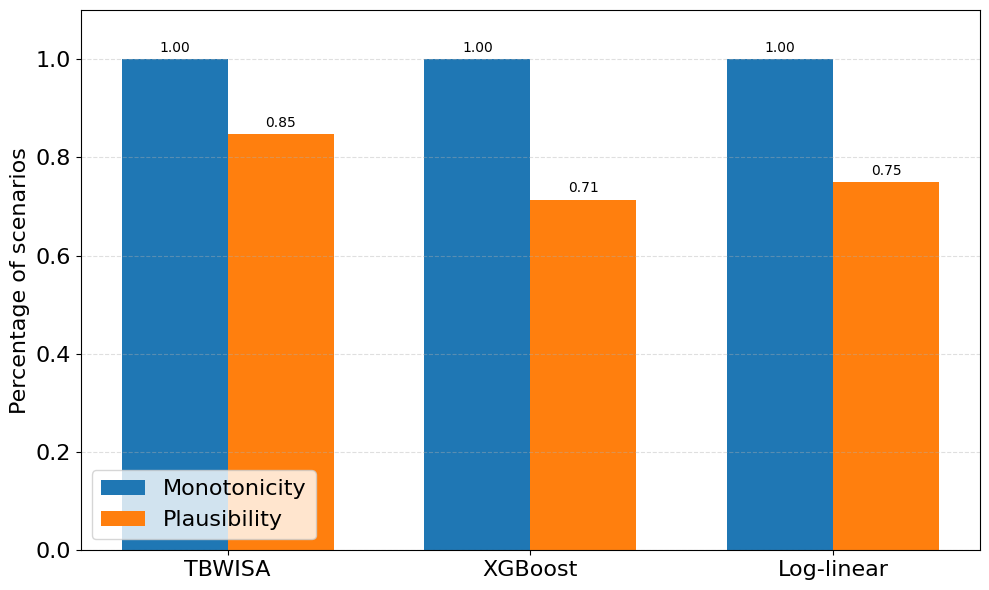

In [58]:
models = ["TBWISA", "XGBoost", "Log-linear"]
monotonicity = [1.0, 1.0, 1.0]
plausibility = [0.847, 0.714, 0.75]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, monotonicity, width, label="Monotonicity")
rects2 = ax.bar(x + width/2, plausibility, width, label="Plausibility")

ax.set_ylabel("Percentage of scenarios", fontsize=plot_font_size)
#ax.set_title("Scenario Structural Validation by Model")
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=plot_font_size)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=plot_font_size, loc=3)
ax.bar_label(rects1, fmt="%.2f", padding=3)
ax.bar_label(rects2, fmt="%.2f", padding=3)
plt.xticks(fontsize=plot_font_size, rotation=0)
plt.yticks(fontsize=plot_font_size)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


## Test the sensitivity to elasticity estimation errors 

In [59]:
def test_elasticity_sensitivity_with_framework(data, input_col, output_col, noise_levels, runs=30):
    generator = TBWISAGenerator()

    results = []

    # Extract baseline elasticity, intercept, residuals
    base_elasticity, base_intercept, base_residuals = generator.calculate_structural_elasticity(
        data[input_col], data[output_col])

    log_price = np.log(data[input_col].values)
    log_demand = np.log(data[output_col].values)

    # Baseline model fit and error
    baseline_model = LinearRegression()
    baseline_model.fit(log_price.reshape(-1, 1), log_demand.reshape(-1, 1))
    baseline_pred_log_demand = baseline_model.predict(log_price.reshape(-1, 1))
    baseline_pred_demand = np.exp(baseline_pred_log_demand.flatten())
    baseline_mape = np.mean(np.abs((baseline_pred_demand - data[output_col].values) / data[output_col].values))

    results.append({
        "noise_std": 0.0,
        "avg_elasticity": base_elasticity,
        "std_elasticity": 0.0,
        "avg_mape": baseline_mape,
        "std_mape": 0.0
    })

    # Run tests with noise
    for noise_std in noise_levels:
        elasticity_vals = []
        mape_vals = []

        for _ in range(runs):
            noisy_log_price = log_price + np.random.normal(0, noise_std, size=log_price.shape)
            model = LinearRegression()
            model.fit(noisy_log_price.reshape(-1, 1), log_demand.reshape(-1, 1))
            estimated_elasticity = model.coef_[0][0]
            elasticity_vals.append(estimated_elasticity)

            pred_log_demand = model.predict(noisy_log_price.reshape(-1, 1))
            pred_demand = np.exp(pred_log_demand.flatten())

            mape = np.mean(np.abs((pred_demand - data[output_col].values) / data[output_col].values))
            mape_vals.append(mape)

        results.append({
            "noise_std": noise_std,
            "avg_elasticity": np.mean(elasticity_vals),
            "std_elasticity": np.std(elasticity_vals),
            "avg_mape": np.mean(mape_vals),
            "std_mape": np.std(mape_vals)
        })

    return pd.DataFrame(results)

In [60]:
# Run analysis
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sensitivity_df = test_elasticity_sensitivity_with_framework(data, input_col, output_col, noise_levels)

# Save or print results
print(sensitivity_df)
# sensitivity_df.to_csv("elasticity_sensitivity_results.csv", index=False)

    noise_std  avg_elasticity  std_elasticity  avg_mape  std_mape
0        0.00       -1.510267        0.000000  0.014619  0.000000
1        0.01       -1.510985        0.017315  0.017873  0.002555
2        0.05       -1.417039        0.117921  0.054403  0.008743
3        0.10       -1.130439        0.167705  0.103923  0.015133
4        0.20       -0.639558        0.124205  0.152941  0.023818
5        0.30       -0.342684        0.130496  0.186436  0.027554
6        0.40       -0.233560        0.138348  0.188676  0.031510
7        0.50       -0.128346        0.092923  0.210551  0.021228
8        0.60       -0.083673        0.079337  0.214133  0.019091
9        0.70       -0.062941        0.082333  0.212016  0.023176
10       0.80       -0.064199        0.073786  0.212758  0.019880
11       0.90       -0.041003        0.061842  0.216357  0.018433
12       1.00       -0.035960        0.065162  0.216443  0.017294


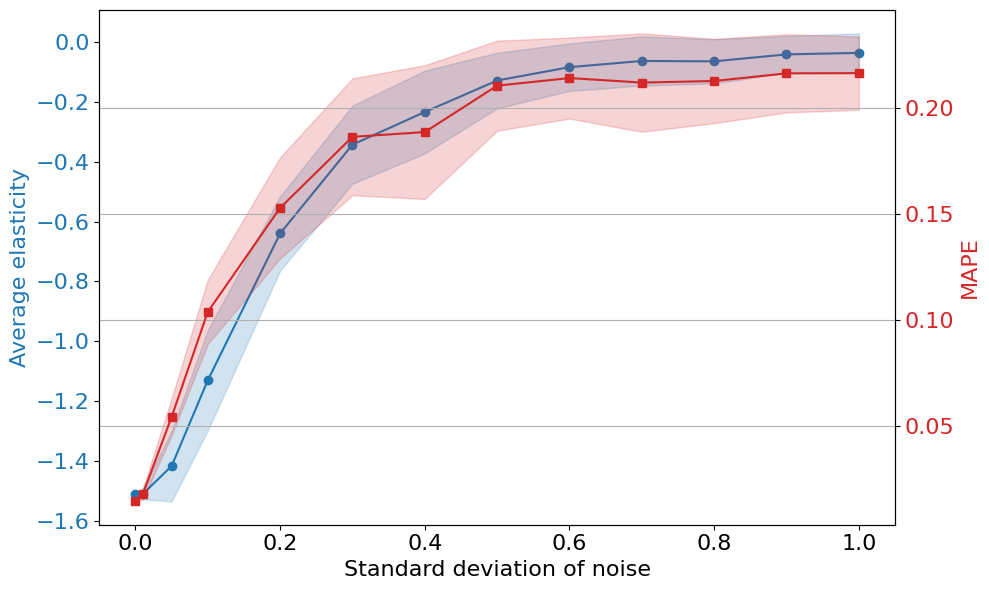

In [62]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Standard deviation of noise", fontsize=plot_font_size)
ax1.set_ylabel("Average elasticity", color=color, fontsize=plot_font_size)
ax1.plot(sensitivity_df["noise_std"], sensitivity_df["avg_elasticity"], marker='o', color=color, label="Avg Elasticity")
ax1.fill_between(sensitivity_df["noise_std"],
                 sensitivity_df["avg_elasticity"] - sensitivity_df["std_elasticity"],
                 sensitivity_df["avg_elasticity"] + sensitivity_df["std_elasticity"],
                 color=color, alpha=0.2, label="Elasticity ± Std")
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(fontsize=plot_font_size)
plt.yticks(fontsize=plot_font_size)

ax2 = ax1.twinx()  # secondary y-axis
color = 'tab:red'
ax2.set_ylabel("MAPE", color=color, fontsize=plot_font_size)
ax2.plot(sensitivity_df["noise_std"], sensitivity_df["avg_mape"], marker='s', color=color, label="Avg MAPE")
ax2.fill_between(sensitivity_df["noise_std"],
                 sensitivity_df["avg_mape"] - sensitivity_df["std_mape"],
                 sensitivity_df["avg_mape"] + sensitivity_df["std_mape"],
                 color=color, alpha=0.2, label="MAPE ± Std")
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(fontsize=plot_font_size)
plt.yticks(fontsize=plot_font_size)

fig.tight_layout()
#plt.title("Sensitivity to Elasticity Estimation Noise")
plt.grid(True)
plt.show()

